In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
from jax import vmap, jit
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
import seaborn as sns
from hflow.misc.plot import scatter_movie, imshow_movie, line_movie
from hflow.run import build
from hflow.io.load import load_single, load_multi
from hflow.misc.multiplot import series_plotter, plot_df_nested
import random

In [3]:
def get_min_row(df, col):
    i = df[col].idxmin()
    return i, df.loc[i]

In [17]:
cfgs, df = load_multi('vtwo', '171451338821')

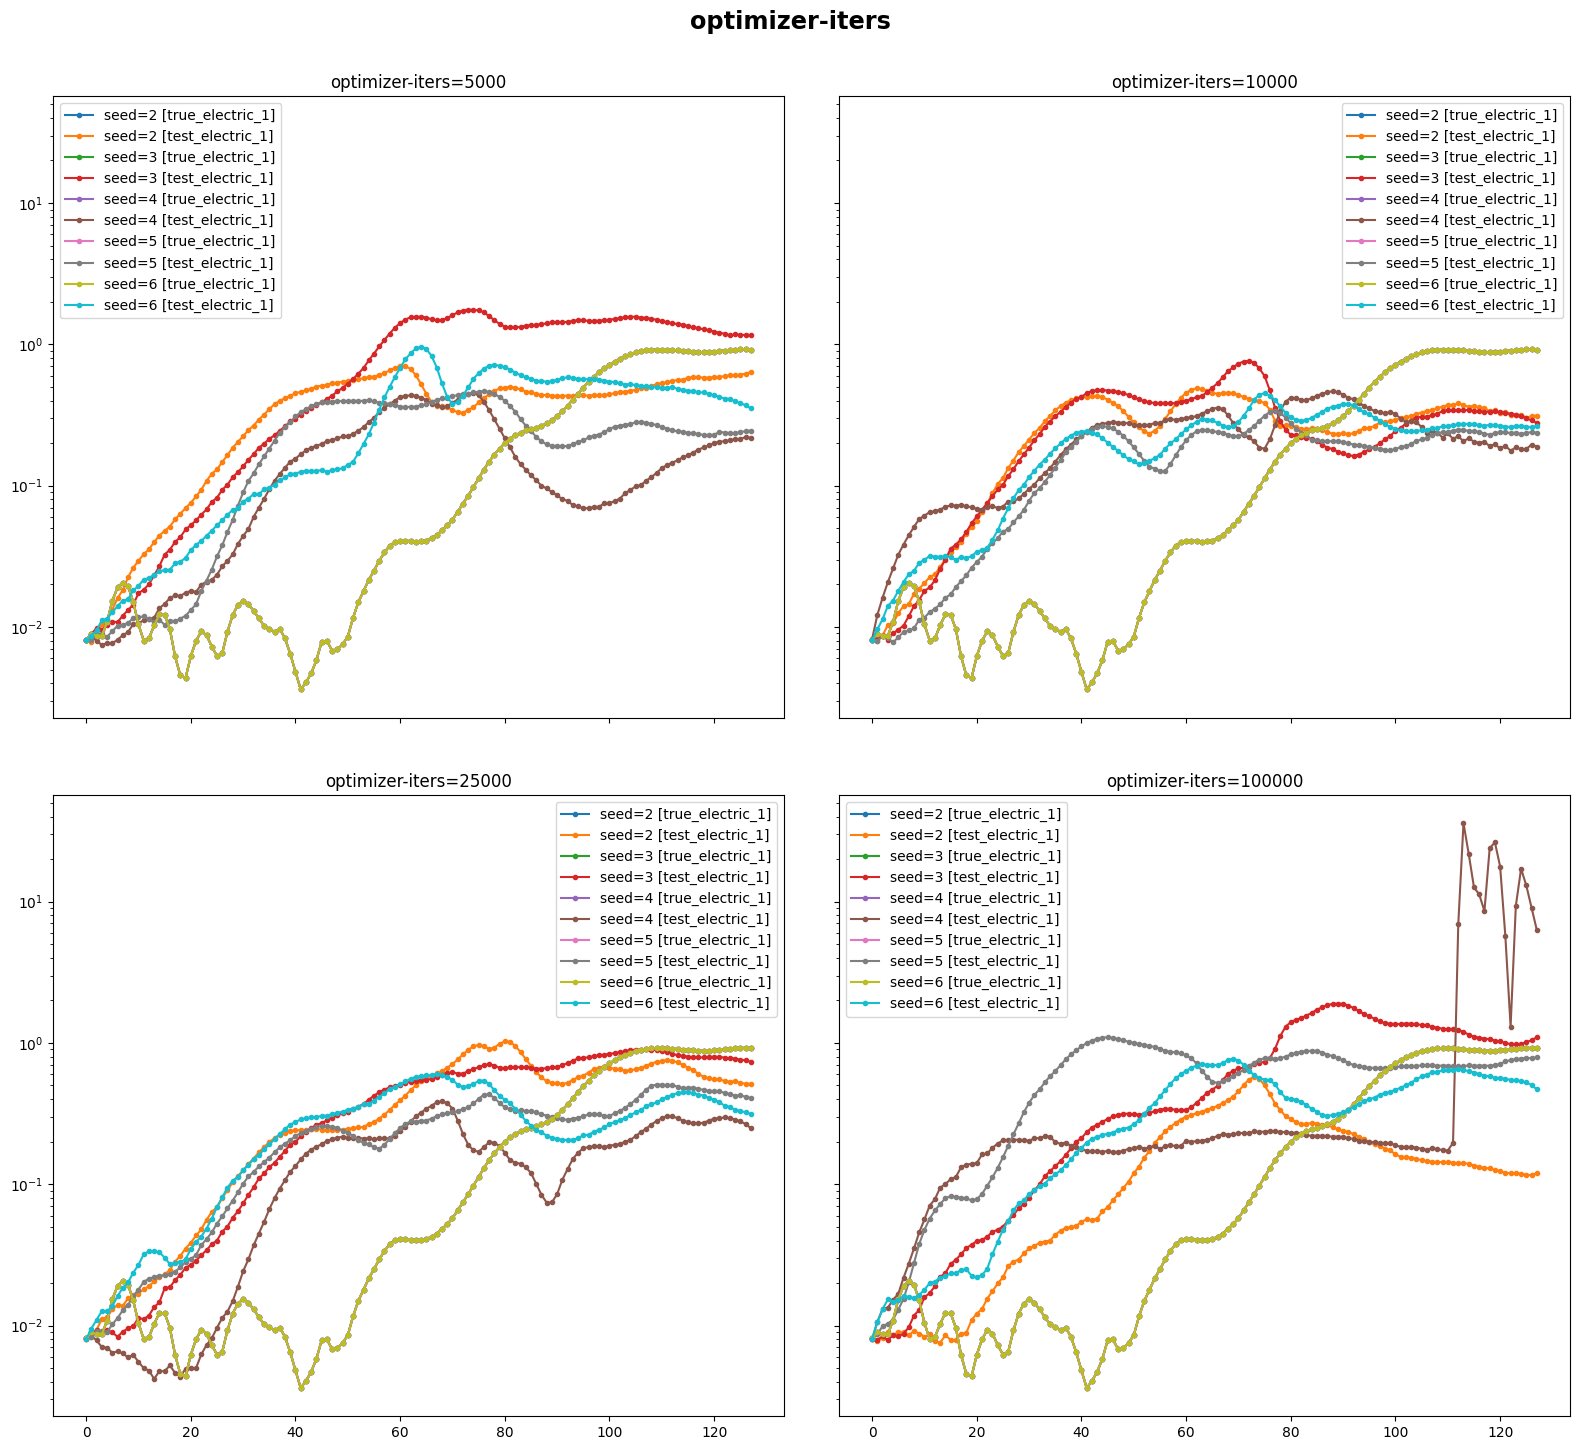

In [18]:

plotter = series_plotter(['true_electric_1', 'test_electric_1'], lines=['seed'], logy=True)
plot_df_nested(df, plotter, layers=['optimizer-iters'], sharey=True)

In [14]:
cfgs, df = load_multi('vsingle', '171456956693')

did not load:  results/vsingle/multi/171456956693/7
did not load:  results/vsingle/multi/171456956693/6
did not load:  results/vsingle/multi/171456956693/11
did not load:  results/vsingle/multi/171456956693/9
did not load:  results/vsingle/multi/171456956693/10
did not load:  results/vsingle/multi/171456956693/8


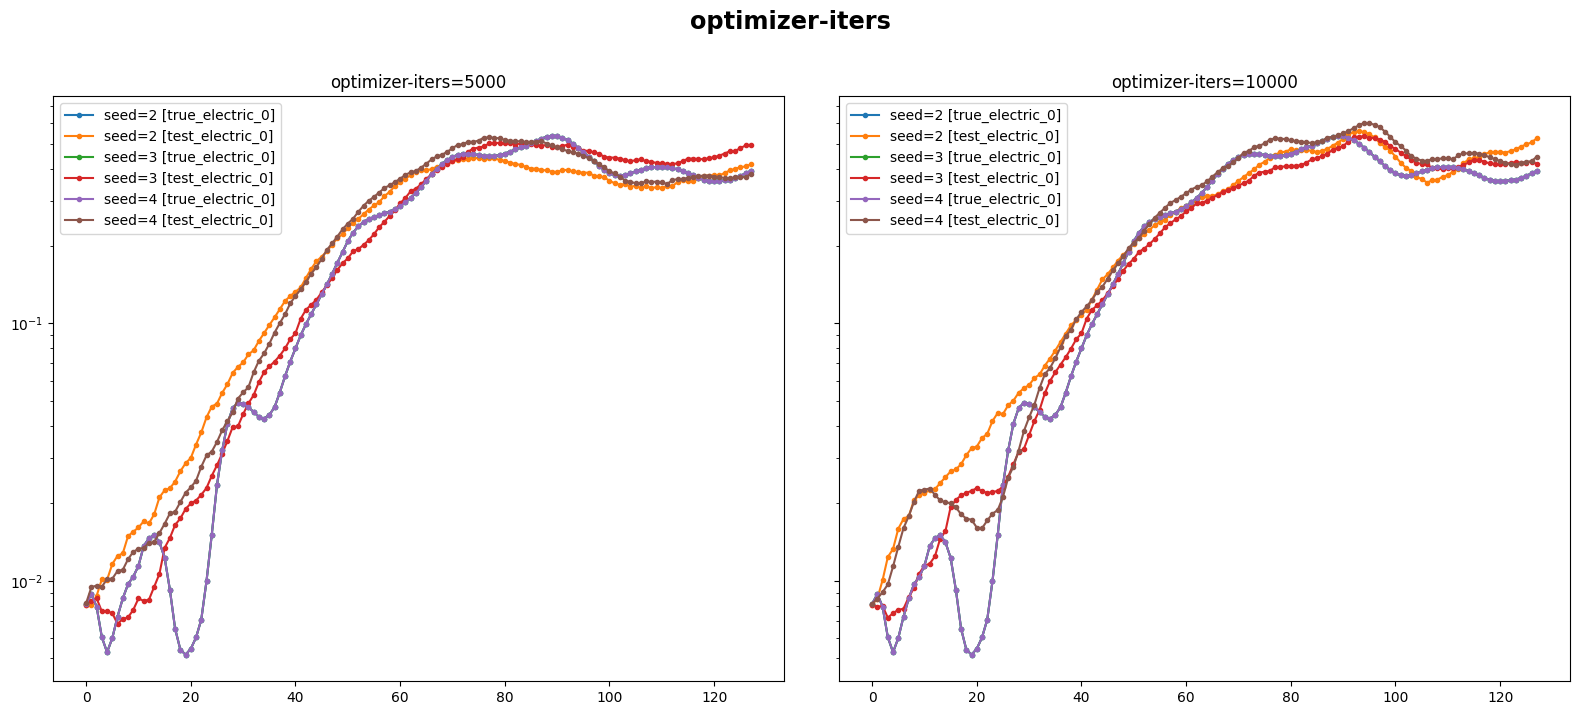

In [15]:

plotter = series_plotter(['true_electric_0', 'test_electric_0'], lines=['seed'], logy=True)
plot_df_nested(df, plotter, layers=['optimizer-iters'], sharey=True)

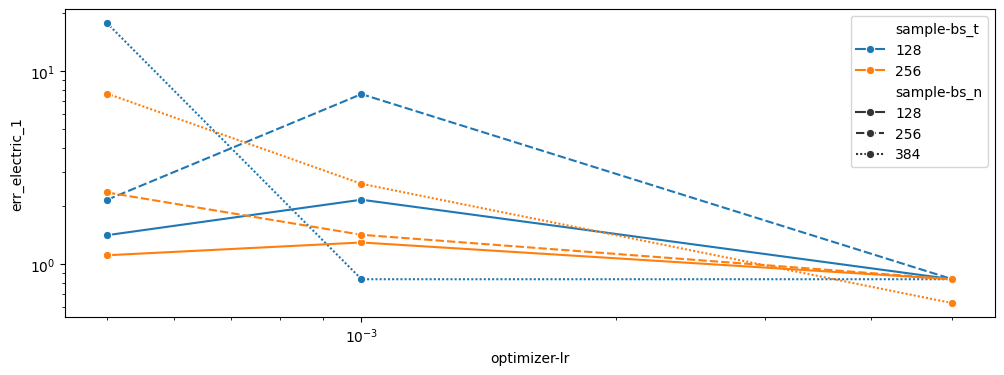

In [52]:

f, ax = plt.subplots(figsize=(12, 4))
ax.set(yscale="log", xscale="log")
p = sns.lineplot(df_sub, x='optimizer-lr', y='err_electric_1', hue='sample-bs_t', style='sample-bs_n', marker="o", palette='tab10')
plt.show()

In [133]:
def get_min_row(df, col):
    i = df[col].idxmin()
    return i, df.loc[i]

In [120]:
i, row = get_min_row(df, 'err_electric_0')
cfg = cfgs[i]


In [121]:
row['optimizer-lr'], row['optimizer-iters'],row['sample-bs_t'], row['sample-bs_n']

(0.0005, 100000, 256, 128)

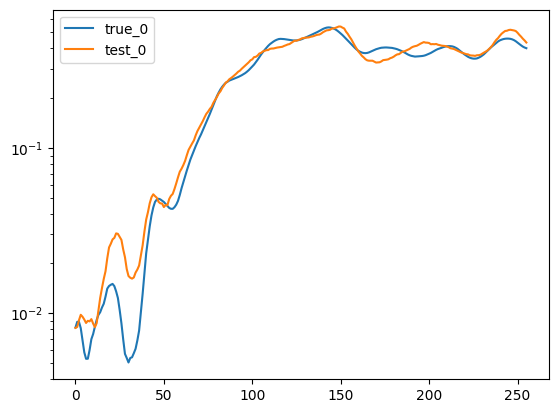

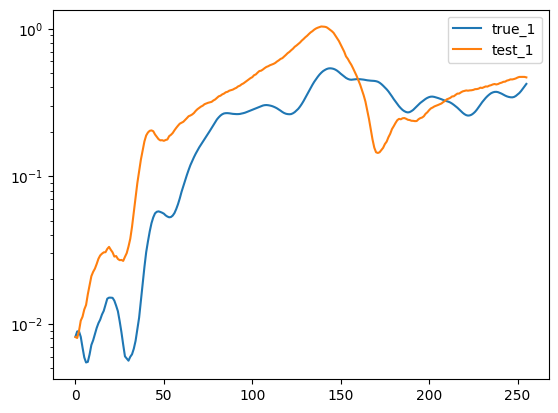

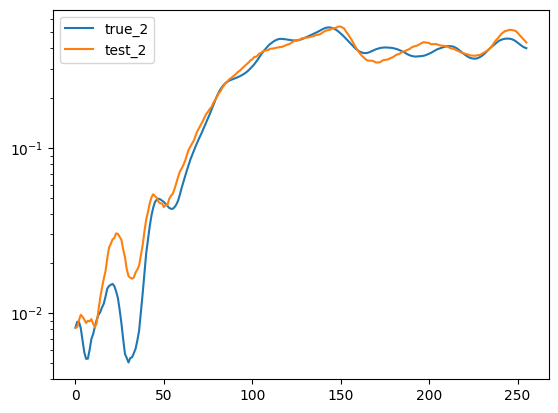

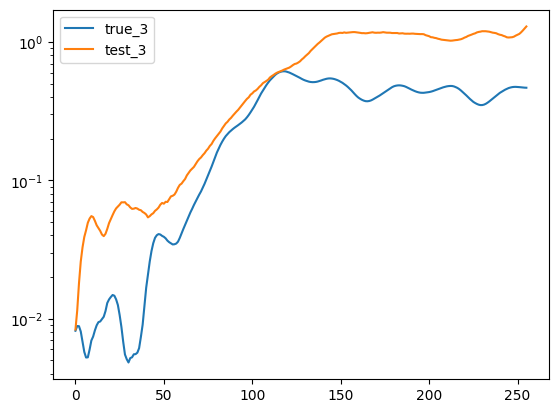

In [122]:
for i,m in enumerate(row['train_mus']):
    plt.semilogy(row[f'true_electric_{i}'], label=f'true_{i}')
    plt.semilogy(row[f'test_electric_{i}'],  label=f'test_{i}')
    plt.legend()
    plt.show()

In [123]:
from hflow.test.plot import get_hist

H = get_hist(row['test_sol_0'])

In [124]:
imshow_movie(H)

In [125]:
from hflow.run import build
from hflow.config import Config

key, train_data, test_data, loss_fn, arg_fn, s_fn, params_init = build(cfg)

In [126]:
opt_params = row['opt_params']

In [130]:
from hflow.misc.misc import pts_array_from_space
from jax import jit, jvp, grad, jacrev, jacfwd
from functools import partial

s_Vx = vmap(s_fn, in_axes=(None, 0, None))
s_Vx_Vt = vmap(s_Vx, in_axes=(0, None, None))

nx = 80
nt = 50
xx = np.linspace(0,1,nx)
x_grid = pts_array_from_space([xx,xx])

mu = row['test_mus'][0]
t_test = np.linspace(0,1,nt).reshape(-1, 1)

mu_t= np.hstack([ np.asarray([mu]*len(t_test)), t_test  ])


pred = s_Vx_Vt(mu_t, x_grid, opt_params)
pred = rearrange(pred, 'T (N1 N2)-> (T) N1 N2', T=len(t_test), N1=nx, N2=nx)

imshow_movie(pred, live_cbar=True)
